<a href="https://colab.research.google.com/github/Verethraghnah/30m/blob/main/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# Requirements
!pip install yahoo_fin
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 10.5 MB/s 
     |████████████████████████████████| 83 kB 2.1 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 106 kB 66.7 MB/s 
     |████████████████████████████████| 127 kB 67.6 MB/s 
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=dec9545556627ac89da54494f8b26c85b1a5631eafa7d0012ee5aadee64b9bd5
  Stored in directory: /root/.cache/pip/wheels/e5/33/1f/68392720485b3ecf125a69e700baaab7624616deedea2fa6e2
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=7b00050c775f6fdc97e5fad8f12b34d28fe25547de343517878d79de25b4b730
  Stored in directory: /root/.cache/pip/wheels/83/63/2f/117884c3b19d46b64d3d61690333aa80c88dc14050e269c546
Successfully built parse sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'BTC-USD'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=365*5)).strftime('%Y-%m-%d')

In [4]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [5]:
init_df

,open,high,low,close,adjclose,volume,ticker
2017-12-13,17500.000000,17653.099609,16039.700195,16408.199219,16408.199219,12976900096,BTC-USD
2017-12-14,16384.599609,17085.800781,16185.900391,16564.000000,16564.000000,13777399808,BTC-USD
2017-12-15,16601.300781,18154.099609,16601.300781,17706.900391,17706.900391,14309999616,BTC-USD
2017-12-16,17760.300781,19716.699219,17515.300781,19497.400391,19497.400391,12740599808,BTC-USD
2017-12-17,19475.800781,20089.000000,18974.099609,19140.800781,19140.800781,13314599936,BTC-USD
...,...,...,...,...,...,...,...
2022-12-08,16847.349609,17267.916016,16788.783203,17233.474609,17233.474609,20496603770,BTC-USD
2022-12-09,17232.148438,17280.546875,17100.835938,17133.152344,17133.152344,20328426366,BTC-USD
2022-12-10,17134.220703,17216.826172,17120.683594,17128.724609,17128.724609,12706781969,BTC-USD
2022-12-11,17129.710938,17245.634766,17091.820312,17104.193359,17104.193359,14122486832,BTC-USD


In [6]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [7]:
init_df

,close,date
2017-12-13,16408.199219,2017-12-13
2017-12-14,16564.000000,2017-12-14
2017-12-15,17706.900391,2017-12-15
2017-12-16,19497.400391,2017-12-16
2017-12-17,19140.800781,2017-12-17
...,...,...
2022-12-08,17233.474609,2022-12-08
2022-12-09,17133.152344,2022-12-09
2022-12-10,17128.724609,2022-12-10
2022-12-11,17104.193359,2022-12-11


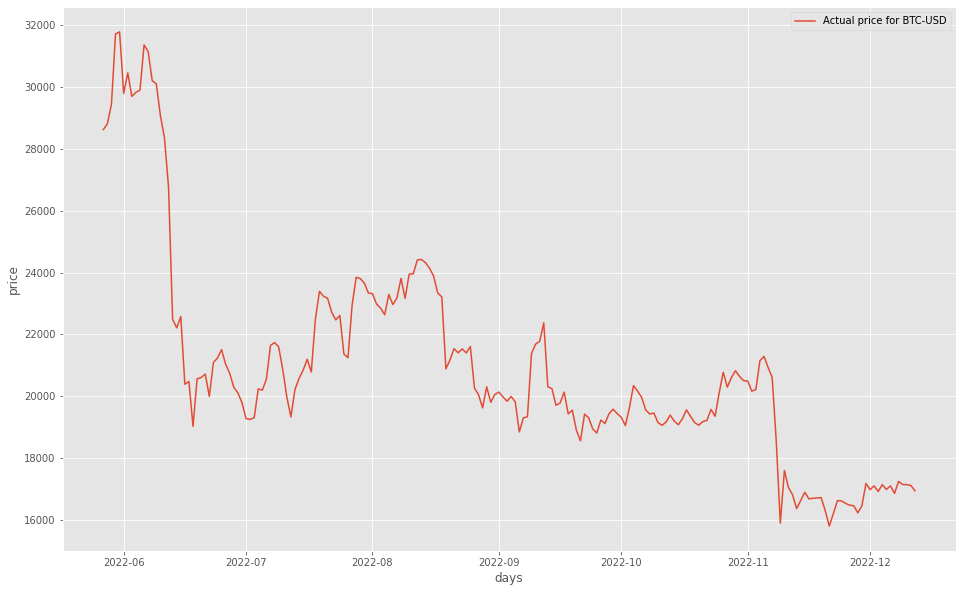

In [8]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [9]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [10]:
init_df

,close,date,scaled_close
2017-12-13,16408.199219,2017-12-13,0.204748
2017-12-14,16564.000000,2017-12-14,0.207170
2017-12-15,17706.900391,2017-12-15,0.224936
2017-12-16,19497.400391,2017-12-16,0.252769
2017-12-17,19140.800781,2017-12-17,0.247226
...,...,...,...
2022-12-08,17233.474609,2022-12-08,0.217577
2022-12-09,17133.152344,2022-12-09,0.216017
2022-12-10,17128.724609,2022-12-10,0.215948
2022-12-11,17104.193359,2022-12-11,0.215567


In [11]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [12]:
PrepareData(3) # 3 days

(                   close       date  scaled_close    future
 2017-12-13  16408.199219 2017-12-13      0.204748  0.252769
 2017-12-14  16564.000000 2017-12-14      0.207170  0.247226
 2017-12-15  17706.900391 2017-12-15      0.224936  0.246812
 2017-12-16  19497.400391 2017-12-16      0.252769  0.226021
 2017-12-17  19140.800781 2017-12-17      0.247226  0.208112
 ...                  ...        ...           ...       ...
 2022-12-05  16974.826172 2022-12-05      0.213556  0.217577
 2022-12-06  17089.503906 2022-12-06      0.215339  0.216017
 2022-12-07  16848.126953 2022-12-07      0.211586  0.215948
 2022-12-08  17233.474609 2022-12-08      0.217577  0.215567
 2022-12-09  17133.152344 2022-12-09      0.216017  0.212867
 
 [1823 rows x 4 columns], array([[0.21252076],
        [0.2159756 ],
        [0.21355589],
        [0.21533853],
        [0.21158637],
        [0.21757653],
        [0.21601704],
        [0.21594821],
        [0.21556687],
        [0.21286725]], dtype=float32), arra

In [13]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 16
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [14]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
114/114 [==============================] - 8s 6ms/step - loss: 0.0089
Epoch 2/80
114/114 [==============================] - 1s 7ms/step - loss: 0.0019
Epoch 3/80
114/114 [==============================] - 1s 7ms/step - loss: 0.0017
Epoch 4/80
114/114 [==============================] - 1s 7ms/step - loss: 0.0021
Epoch 5/80
114/114 [==============================] - 1s 6ms/step - loss: 0.0018
Epoch 6/80
114/114 [==============================] - 1s 6ms/step - loss: 0.0017
Epoch 7/80
114/114 [==============================] - 1s 7ms/step - loss: 0.0015
Epoch 8/80
114/114 [==============================] - 1s 6ms/step - loss: 0.0016
Epoch 9/80
114/114 [==============================] - 1s 6ms/step - loss: 0.0016
Epoch 10/80
114/114 [==============================] - 1s 7ms/step - loss: 0.0016
Epoch 11/80
114/114 [==============================] - 1s 6ms/step - loss: 0.0013
Epoch 12/80
114/114 [==============================] - 1s 7ms/step - loss: 0.0015
Epoch 13/80
114/114 [====

In [15]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
  
  print(message)

BTC-USD prediction for upcoming 3 days (17055.36$, 16988.61$, 17177.4$)


In [17]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

57/57 [==============================] - 0s 3ms/step


In [18]:
copy_df

,close,date,scaled_close,predicted_close
2017-12-13,16408.199219,2017-12-13,0.204748,13831.799805
2017-12-14,16564.000000,2017-12-14,0.207170,14699.200195
2017-12-15,17706.900391,2017-12-15,0.224936,13925.799805
2017-12-16,19497.400391,2017-12-16,0.252769,14026.599609
2017-12-17,19140.800781,2017-12-17,0.247226,16099.799805
...,...,...,...,...
2022-12-08,17233.474609,2022-12-08,0.217577,17257.197266
2022-12-09,17133.152344,2022-12-09,0.216017,17292.607422
2022-12-10,17128.724609,2022-12-10,0.215948,17128.724609
2022-12-11,17104.193359,2022-12-11,0.215567,17104.193359


In [19]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:3361: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.get_loc(casted_key)


In [20]:
copy_df

,close,date,scaled_close,predicted_close
2017-12-13 00:00:00,16408.199219,2017-12-13 00:00:00,0.204748,13831.799805
2017-12-14 00:00:00,16564.000000,2017-12-14 00:00:00,0.207170,14699.200195
2017-12-15 00:00:00,17706.900391,2017-12-15 00:00:00,0.224936,13925.799805
2017-12-16 00:00:00,19497.400391,2017-12-16 00:00:00,0.252769,14026.599609
2017-12-17 00:00:00,19140.800781,2017-12-17 00:00:00,0.247226,16099.799805
...,...,...,...,...
2022-12-11 00:00:00,17104.193359,2022-12-11 00:00:00,0.215567,17104.193359
2022-12-12 00:00:00,16930.525391,2022-12-12 00:00:00,0.212867,16930.525391
2022-12-12,17055.360000,2022-12-12,0.000000,0.000000
2022-12-13,16988.610000,2022-12-13,0.000000,0.000000


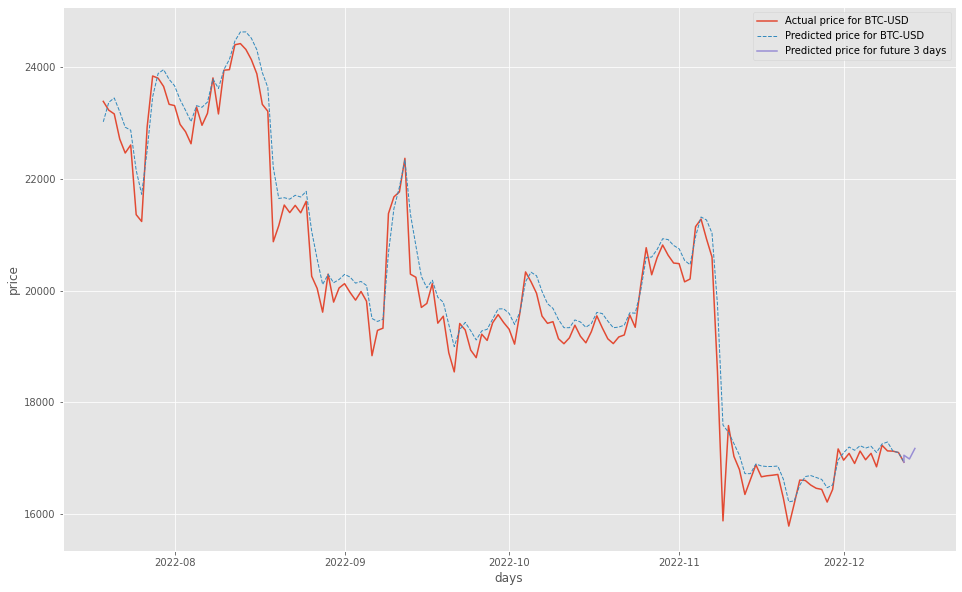

In [22]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()